In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import tqdm
import utils as utils
import cartopy.crs as ccrs
import regionmask
import pandas as pd

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import src.evaluation.visualisation as vis

In [3]:
groundtruth =  xr.open_dataarray('./netcdf/hist_aer_NorESM2_LM.nc')
pattern_scaling =  xr.open_dataarray('./netcdf/hist_aer_pattern_scaling.nc')
plain_gp =  xr.open_dataarray('./netcdf/hist_aer_plain_gp.nc')
fairgp =  xr.open_dataarray('./netcdf/hist_aer_fairgp.nc')

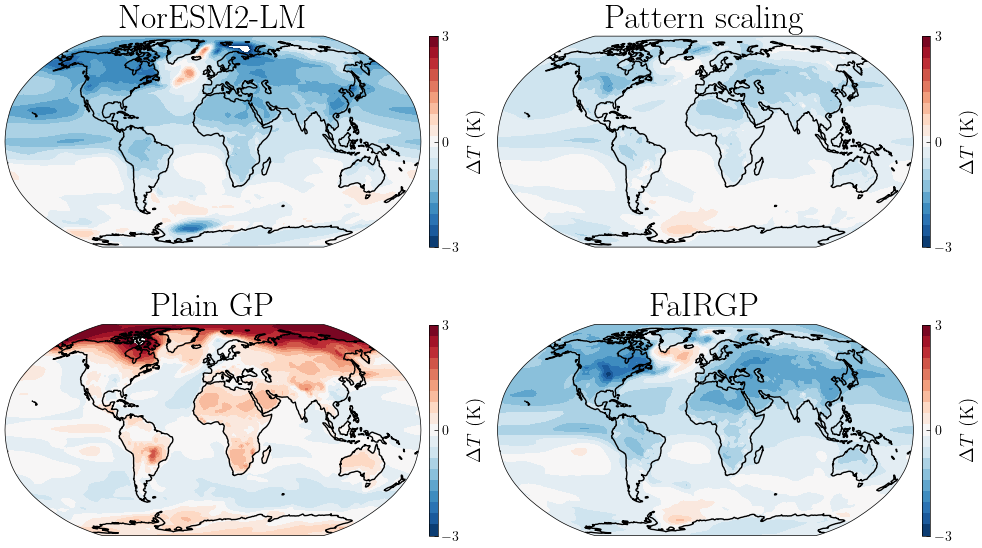

In [4]:
start, end = 1980, 2014
time_slice = slice(start, end)

vmax = 3
ticks = [-vmax, 0, vmax]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})


_, __, cbar = vis.plot_contourf_on_ax(groundtruth.sel(time=time_slice).mean(dim='time'),
                        fig, ax[0, 0], colorbar=True, vmax=vmax)
cbar.set_ticks(ticks)

_, __, cbar = vis.plot_contourf_on_ax(pattern_scaling.sel(time=time_slice).mean(dim='time'),
                        fig, ax[0, 1], colorbar=True, vmax=vmax)
cbar.set_ticks(ticks)

_, __, cbar = vis.plot_contourf_on_ax(plain_gp.sel(time=time_slice).mean(dim='time'),
                        fig, ax[1, 0], colorbar=True, vmax=vmax)
cbar.set_ticks(ticks)

_, __, cbar = vis.plot_contourf_on_ax(fairgp.sel(time=time_slice).mean(dim='time'),
                        fig, ax[1, 1], colorbar=True, vmax=vmax)
cbar.set_ticks(ticks)

ax[0, 0].set_title("NorESM2-LM", fontsize=24)
ax[0, 1].set_title("Pattern scaling", fontsize=24)
ax[1, 0].set_title("Plain GP", fontsize=24)
ax[1, 1].set_title("FaIRGP", fontsize=24)

plt.tight_layout()
# plt.savefig('./figures/hist-aer-spatial-prediction-1980-2014-paper-plot.jpg', dpi=200)
plt.show()

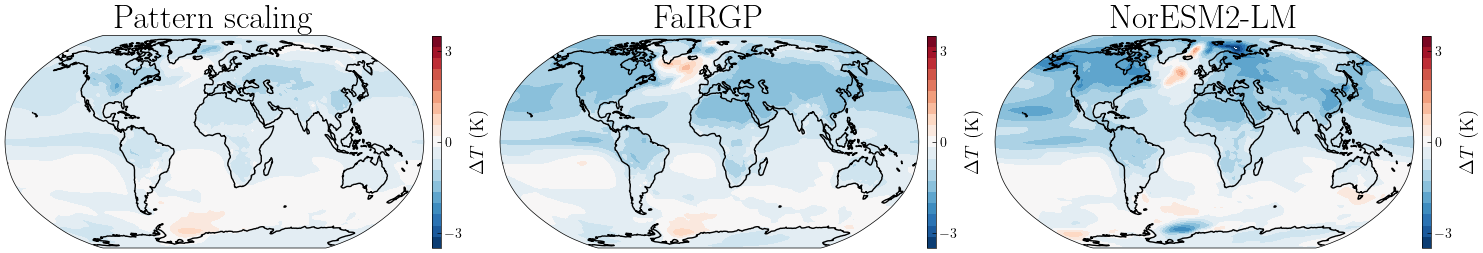

In [5]:
start, end = 1980, 2014
time_slice = slice(start, end)

vmax = 3.5
ticks = [-3, 0, 3]

fig, ax = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.Robinson()})


_, __, cbar = vis.plot_contourf_on_ax(pattern_scaling.sel(time=time_slice).mean(dim='time'),
                        fig, ax[0], colorbar=True, vmax=vmax, levels=20)
cbar.set_ticks(ticks)

_, __, cbar = vis.plot_contourf_on_ax(fairgp.sel(time=time_slice).mean(dim='time').clip(min=-1.5),
                        fig, ax[1], colorbar=True, vmax=vmax, levels=20)
cbar.set_ticks(ticks)

_, __, cbar = vis.plot_contourf_on_ax(groundtruth.sel(time=time_slice).mean(dim='time'),
                        fig, ax[2], colorbar=True, vmax=vmax, levels=20)
cbar.set_ticks(ticks)

ax[0].set_title("Pattern scaling", fontsize=24)
ax[1].set_title("FaIRGP", fontsize=24)
ax[2].set_title("NorESM2-LM", fontsize=24)

plt.tight_layout()
# plt.savefig('./figures/hist-aer-spatial-prediction-1980-2014-paper-plot-without-plaingp.jpg', dpi=200)
plt.show()

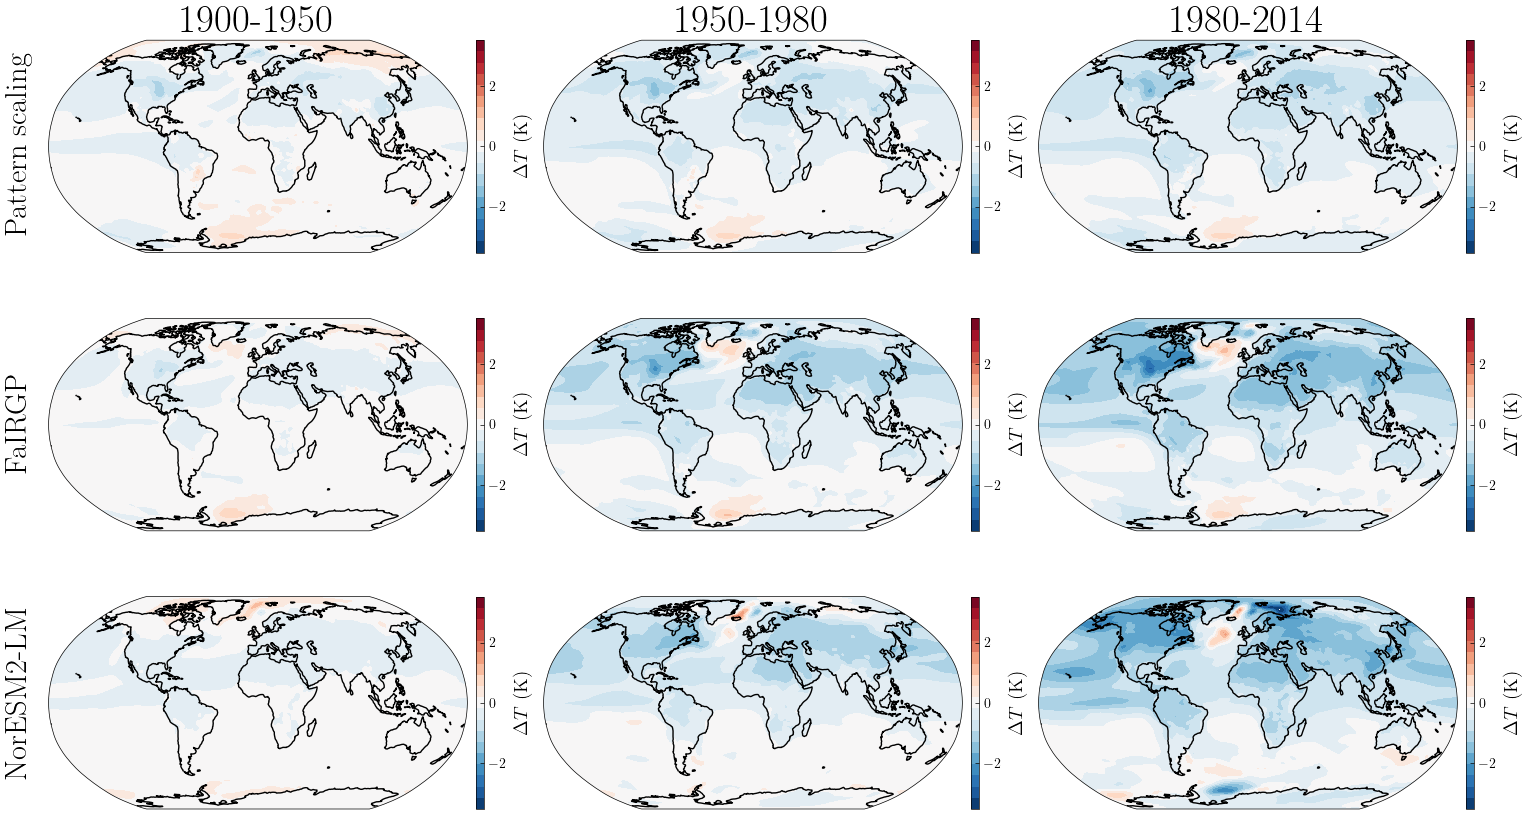

In [6]:
years = [(1900, 1950), (1950, 1980), (1980, 2014)]

ncol = len(years)
vmax = max(fairgp.values.max(), groundtruth.values.max())
ticks = [-2, 0, 2]

fig, ax = plt.subplots(3, ncol, figsize=(ncol * 5, 3 * 3), subplot_kw={'projection': ccrs.Robinson()})

for i in range(ncol):
    start, end = years[i]
    time_slice = slice(start, end)
    
    _, __, cbar = vis.plot_contourf_on_ax(pattern_scaling.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[0, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
    cbar.set_ticks(ticks)
#     cbar.set_ticks([-4, -2, 0, 2, 4])

    _, __, cbar = vis.plot_contourf_on_ax(fairgp.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[1, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
    cbar.set_ticks(ticks)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
#     ax[0, i].set_title(f'{start}-{end}', fontsize=28)

    _, __, cbar = vis.plot_contourf_on_ax(groundtruth.sel(time=time_slice).mean(dim='time'), 
                                          fig, ax[2, i], colorbar=True, vmax=vmax)
    cbar.set_label(r'$\Delta T$ (K)', fontsize=14)
    cbar.set_ticks(ticks)
#     cbar.set_ticks([-4, -2, 0, 2, 4])
    ax[0, i].set_title(f'{start}-{end}', fontsize=28)

fig.text(-0.01, 0.80, 'Pattern scaling', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(-0.01, 0.49, 'FaIRGP', ha='center', va='center', rotation='vertical', fontsize=22)
fig.text(-0.01, 0.19, 'NorESM2-LM', ha='center', va='center', rotation='vertical', fontsize=22)

plt.tight_layout()
# plt.savefig('./figures/hist-aer-spatial-comparison-3-time-periods.png', dpi=200)
plt.show()

# Compute regional scores

In [7]:
def weighted_mean(x, wlat):
    mu = torch.nansum(x * wlat, dim=(1, 2)) / (x.size(2) * wlat.sum())
    return mu

def compute_deterministic_metrics(prediction, groundtruth, wlat):
    # Compute raw distances metrics
    difference = prediction.sub(groundtruth)
    mean_bias = weighted_mean(difference, wlat).mean()
    rmse = weighted_mean(torch.square(difference), wlat).mean().sqrt()
    mae = weighted_mean(torch.abs(difference), wlat).mean()

    # Compute spearman correlation
    isnan = torch.isnan(prediction)
    corr = spearman_correlation(prediction[~isnan].flatten(), groundtruth[~isnan].flatten())

    # Encapsulate results in output dictionnary
    output = {'mb': mean_bias.item(),
              'rmse': rmse.item(),
              'mae': mae.item(),
              'corr': corr}
    return output

def compute_probabilistic_metrics(prediction, groundtruth, wlat):
    ll = weighted_mean(prediction.log_prob(groundtruth), wlat).mean()
    lb, ub = prediction.icdf(torch.tensor(0.025)), prediction.icdf(torch.tensor(0.975))
    mask = (groundtruth >= lb) & (groundtruth <= ub)
    calib95 = weighted_mean(mask.float(), wlat).mean()
    
    mu, sigma = prediction.mean, prediction.stddev
    y = (groundtruth - mu) / sigma
    norm = torch.distributions.Normal(0, 1)
    crps = sigma * (y * (2 * norm.cdf(y) - 1) + 2 * norm.log_prob(y).exp() - 1 / np.sqrt(np.pi))
    crps = weighted_mean(crps, wlat).mean()
    
    output = {'ll': ll.item(),
              'calib95': calib95.item(),
              'CRPS': crps.item()}
    return output

def compute_metrics(xr_prediction, xr_groundtruth, wlat):
    pred = torch.from_numpy(xr_prediction.values).float()
    gt = torch.from_numpy(xr_groundtruth.values).float()
    output = compute_deterministic_metrics(pred, gt, wlat)
    return output

In [8]:
mask = regionmask.defined_regions.srex.mask(groundtruth)
NA_mask = (mask >= 3) & (mask <= 6) # North America
EU_mask = (mask >= 11) & (mask <= 13) # Europe
SEA_mask = (mask == 22) | (mask == 24) # East + South-East Asia
SA_mask = (mask == 23) # South Asia
regions_masks = {'NA': NA_mask,
                 'EU': EU_mask,
                 'SEA': SEA_mask,
                 'SA': SA_mask} 
lat = torch.from_numpy(groundtruth.lat.values).float()
wlat = torch.cos(torch.deg2rad(lat)).clip(min=torch.finfo(torch.float64).eps)[:, None]

In [9]:
mask = NA_mask.astype(int) + \
       2 *  EU_mask.astype(int) + \
       3 * SEA_mask.astype(int) + \
       4 * SA_mask.astype(int)
mask = mask.where(mask > 0)

In [10]:
from matplotlib.colors import ListedColormap
from src.evaluation.metrics import spearman_correlation

In [11]:
Set1 = cm.get_cmap('Set1')
subSet1 = ListedColormap([Set1(0), Set1(1), Set1(2), Set1(3)])

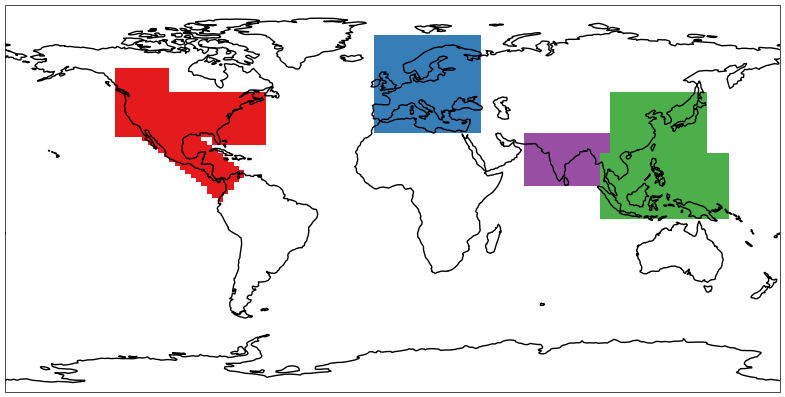

In [12]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 10))
ax.coastlines()

# regionmask.defined_regions.srex.plot(
#     ax=ax, add_label=False, line_kws=dict(lw=0.5, color="0.5")
# )
im = mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=subSet1, add_colorbar=False)
# cbar = plt.colorbar(im, orientation="horizontal", fraction=0.03, pad=0.02)
# step = (cbar.vmax - cbar.vmin) / 4
# cbar.set_ticks(np.array([0, step, 2 * step, 3 * step]) + 1 + step / 2)
# cbar.set_ticklabels(['North America', 'Europe', 'East and \n South-East Asia', 'South Asia'],
#                     fontsize=30, rotation=90)
# cbar.set_label("Region")
# plt.savefig('./figures/regions-map-hist-aer-evaluation.jpg', dpi=200)

In [13]:
pattern_scaling_scores = {}
plain_gp_scores = {}
fairgp_scores = {}
time_slice = slice(1950, 2014)

for region, mask in regions_masks.items():
    pattern_scaling_region = pattern_scaling.sel(time=time_slice).where(mask)
    plain_gp_region = plain_gp.sel(time=time_slice).where(mask)
    fairgp_region = fairgp.sel(time=time_slice).where(mask)
    groundtruth_region = groundtruth.sel(time=time_slice).where(mask)
    
    pattern_scaling_scores.update({region: compute_metrics(pattern_scaling_region,
                                                           groundtruth_region,
                                                           wlat)})
    plain_gp_scores.update({region: compute_metrics(plain_gp_region,
                                                    groundtruth_region,
                                                    wlat)})
    fairgp_scores.update({region: compute_metrics(fairgp_region,
                                                  groundtruth_region,
                                                  wlat)})

In [14]:
scores = {'0Pattern scaling': pattern_scaling_scores,
          '1Plain GP': plain_gp_scores,
          '2FaIRGP': fairgp_scores}
reform = {(outerKey, innerKey): values for outerKey, innerDict in scores.items() for innerKey, values in innerDict.items()}
results = pd.DataFrame(data=reform).T.swaplevel(0, 1).sort_index()
results.columns = ['Bias', 'RMSE', 'MAE', 'Corr']
results = results[['RMSE', 'MAE', 'Bias', 'Corr']]

In [15]:
# results.to_latex('./tables/hist-aer-1950-2014-experiment-regional-scores.tex')
results

/tmp/ipykernel_10263/2432004485.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results.to_latex('./tables/hist-aer-1950-2014-experiment-regional-scores.tex')


RMSE       MAE      Bias      Corr
EU  0Pattern scaling  0.136964  0.018619  0.015108  0.310100
    1Plain GP         0.250267  0.038314  0.037616 -0.158802
    2FaIRGP           0.108387  0.013351  0.003658  0.400233
NA  0Pattern scaling  0.130193  0.023213  0.019388  0.617267
    1Plain GP         0.285500  0.054110  0.053949 -0.097999
    2FaIRGP           0.090702  0.014570 -0.003216  0.722027
SA  0Pattern scaling  0.057993  0.006720  0.005080  0.540763
    1Plain GP         0.124829  0.014987  0.014846 -0.214670
    2FaIRGP           0.037709  0.004041  0.000104  0.723304
SEA 0Pattern scaling  0.138653  0.028587  0.027184  0.764887
    1Plain GP         0.260618  0.051730  0.051516 -0.206888
    2FaIRGP           0.072522  0.013701  0.002991  0.834928